In [23]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import linregress
import signac
#from cmeutils.sampling import equil_sample
from utils import check_job_for_log_equilibrium

#custom_rc_params = matplotlib.rc_params_from_file("../matplotlibrc")
#matplotlib.rcParams.update(custom_rc_params)

In [96]:
def power_scale(x, b):
    return x**b

# Matplotlib RC Params:    
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
symbol_dict = {1.0: "o", 0.8: "s", 0.7: "^", 0.6: "d"}
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['lines.markersize'] = 3
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["legend.markerscale"] = 1

SAVE_FIGS = True
length_unit = "$\sigma$"

# Single Chains

In [2]:
cg_single_chain_proj = signac.get_project("../testing-model/single-chains/")
target_single_chain_proj = signac.get_project("../training-runs/single-chains/")
ss_target_job = target_single_chain_proj.open_job(id="29a7f0d216700e7c8534b8c11140ba06")

## Check for equilibration:

In [19]:
#for job in cg_single_chain_proj.find_jobs({"doc.equilibrated": False}):
for job in target_single_chain_proj.find_jobs({"doc.equilibrated": False}):
    if job.doc.runs != 0:
        check_job_for_log_equilibrium(job, trim_cut=100)

## Chain statistics scaling: C.G. Model

### Radius of Gyration:

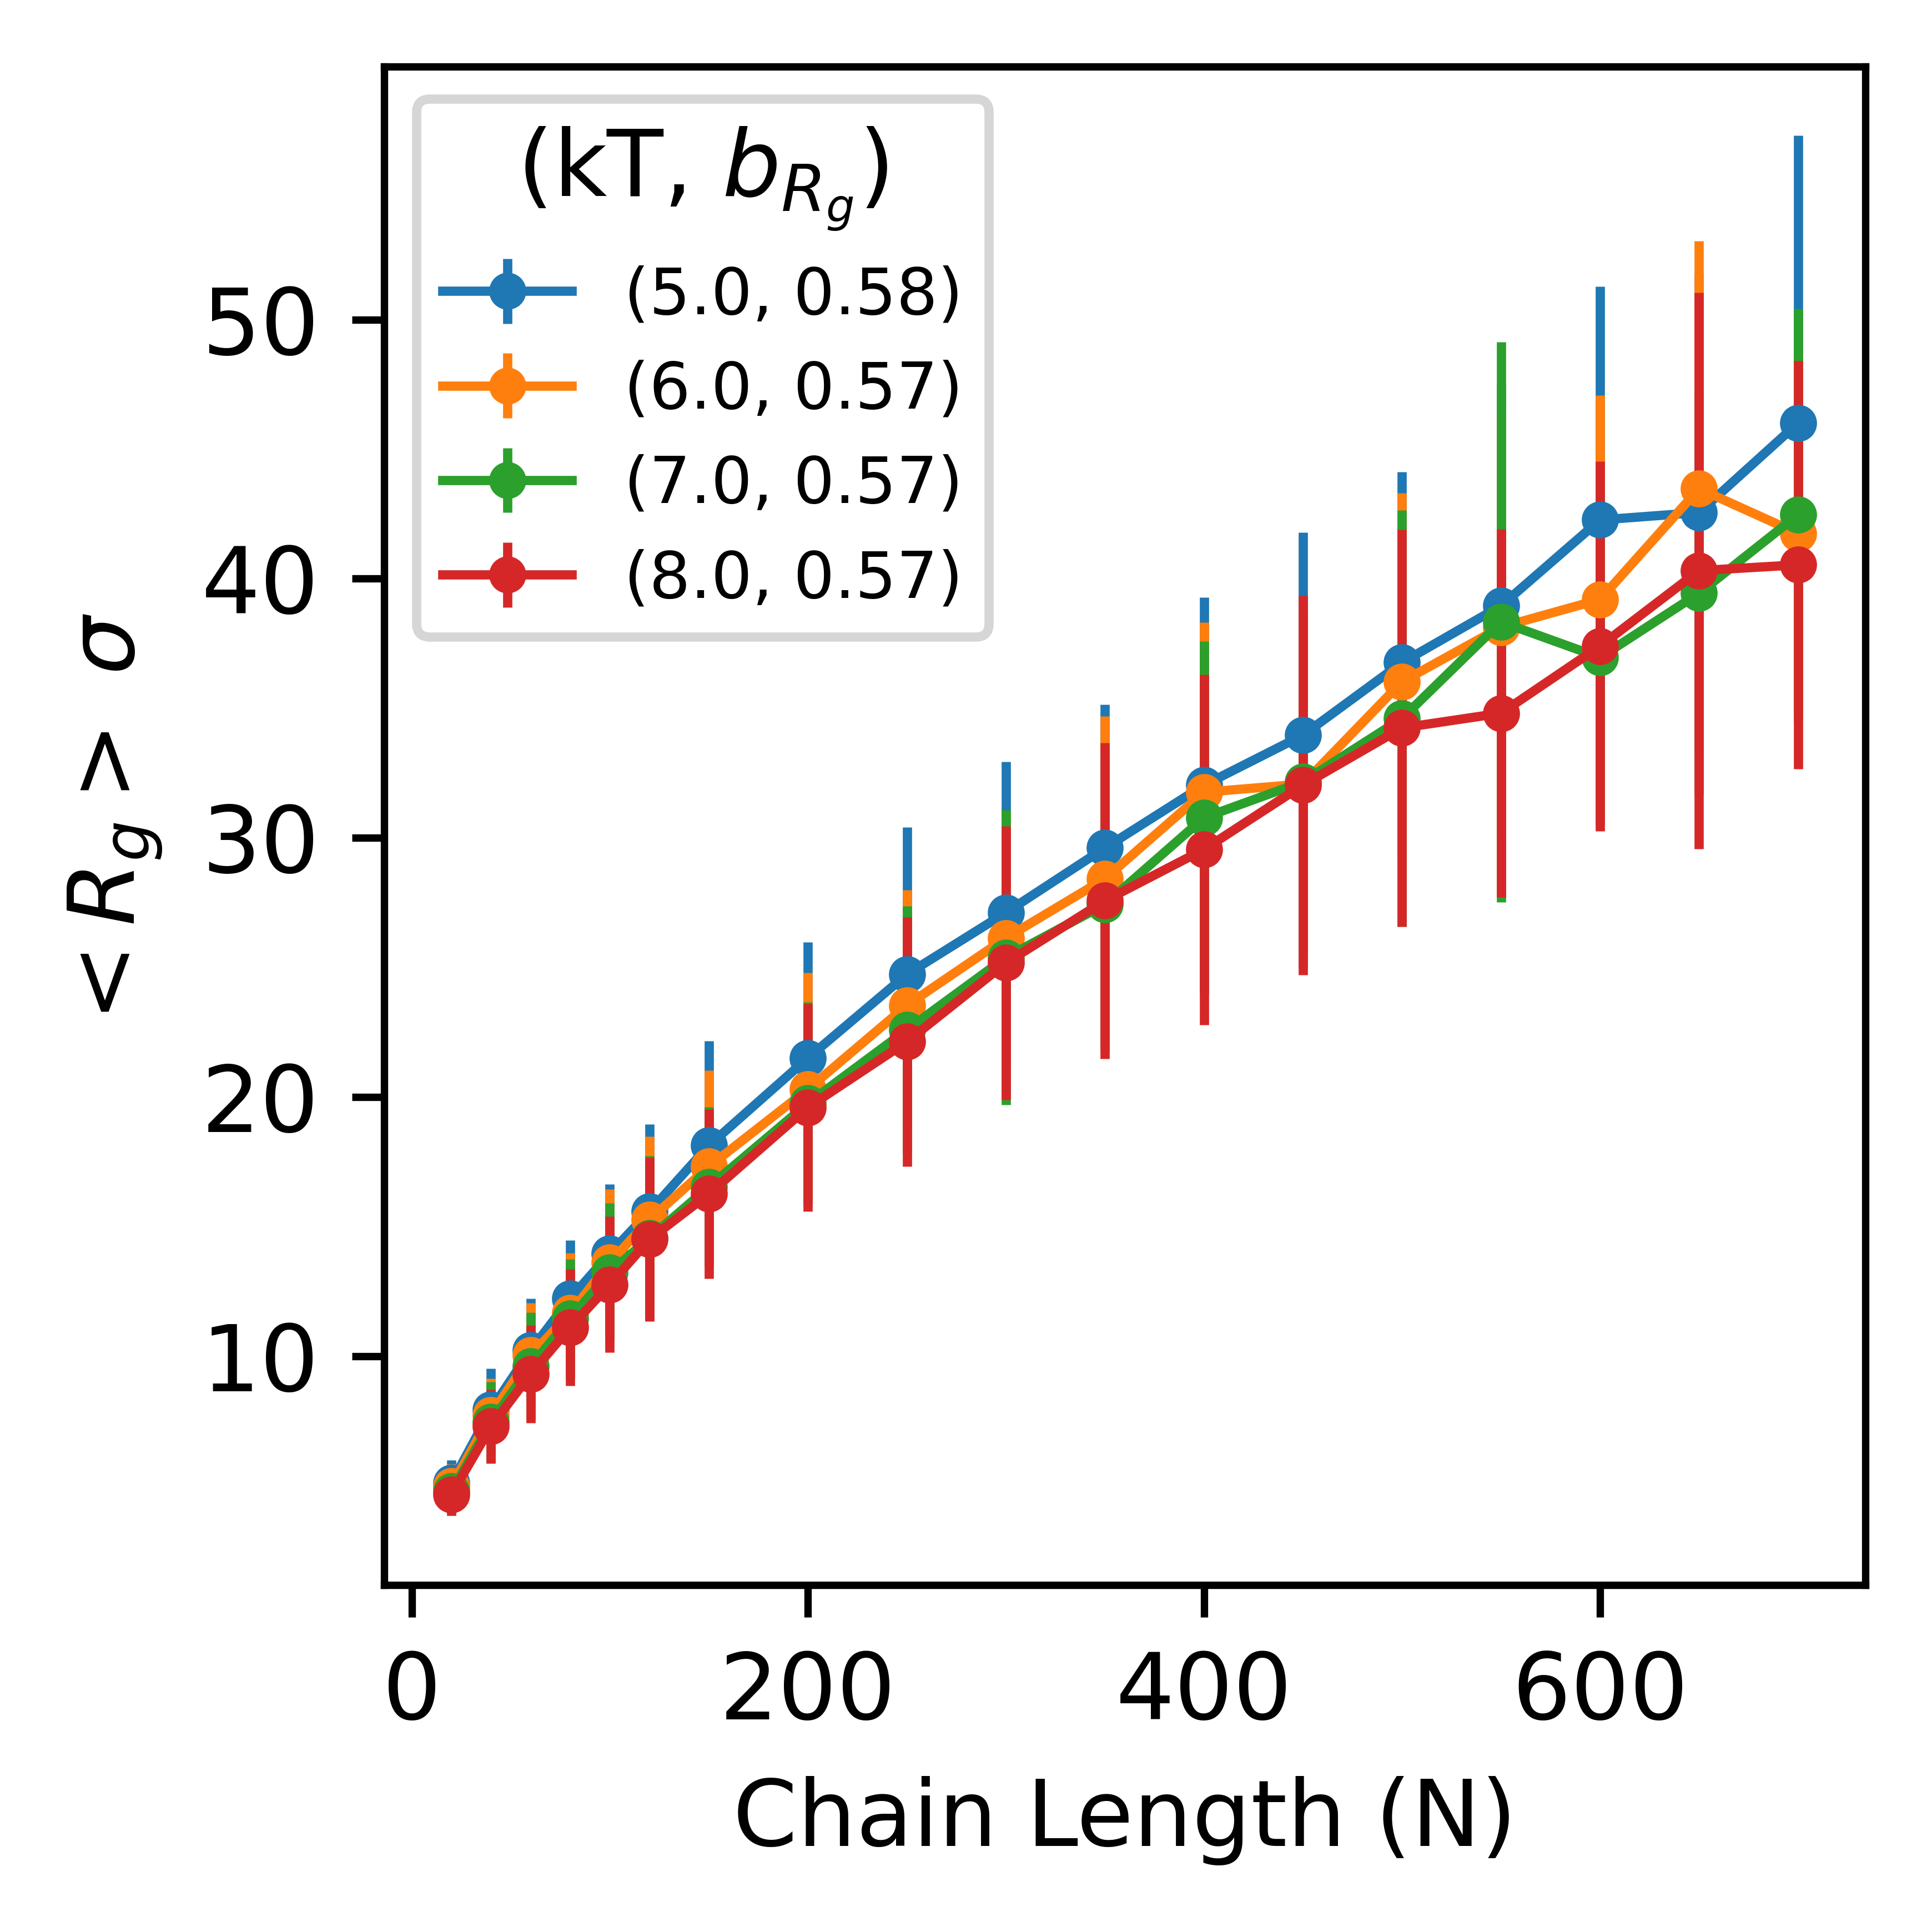

In [99]:
fig = plt.figure()

for kT in [5.0, 6.0, 7.0, 8.0]:
    x = []
    y = []
    y_err = []
    for chain_length, jobs in cg_single_chain_proj.find_jobs(
        {"doc.sampled": True, "kT": kT}).groupby("lengths"):
        for job in jobs:
            x.append(chain_length)
            y.append(job.doc.rg_avg)
            y_err.append(job.doc.rg_std)
    popt, pcov = curve_fit(power_scale, x, y, p0=0.5)
    plt.errorbar(
        x=x,
        y=y,
        yerr=y_err,
        marker="o",
        label=(kT, np.round(popt[0], 2))
    )

plt.legend(title="(kT, $b_{R_g})$")
plt.xlabel("Chain Length (N)")
plt.ylabel(f"$<R_g>$ {length_unit}")
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig("../FIGS/rg-scaling-cg-model.png")
plt.show()

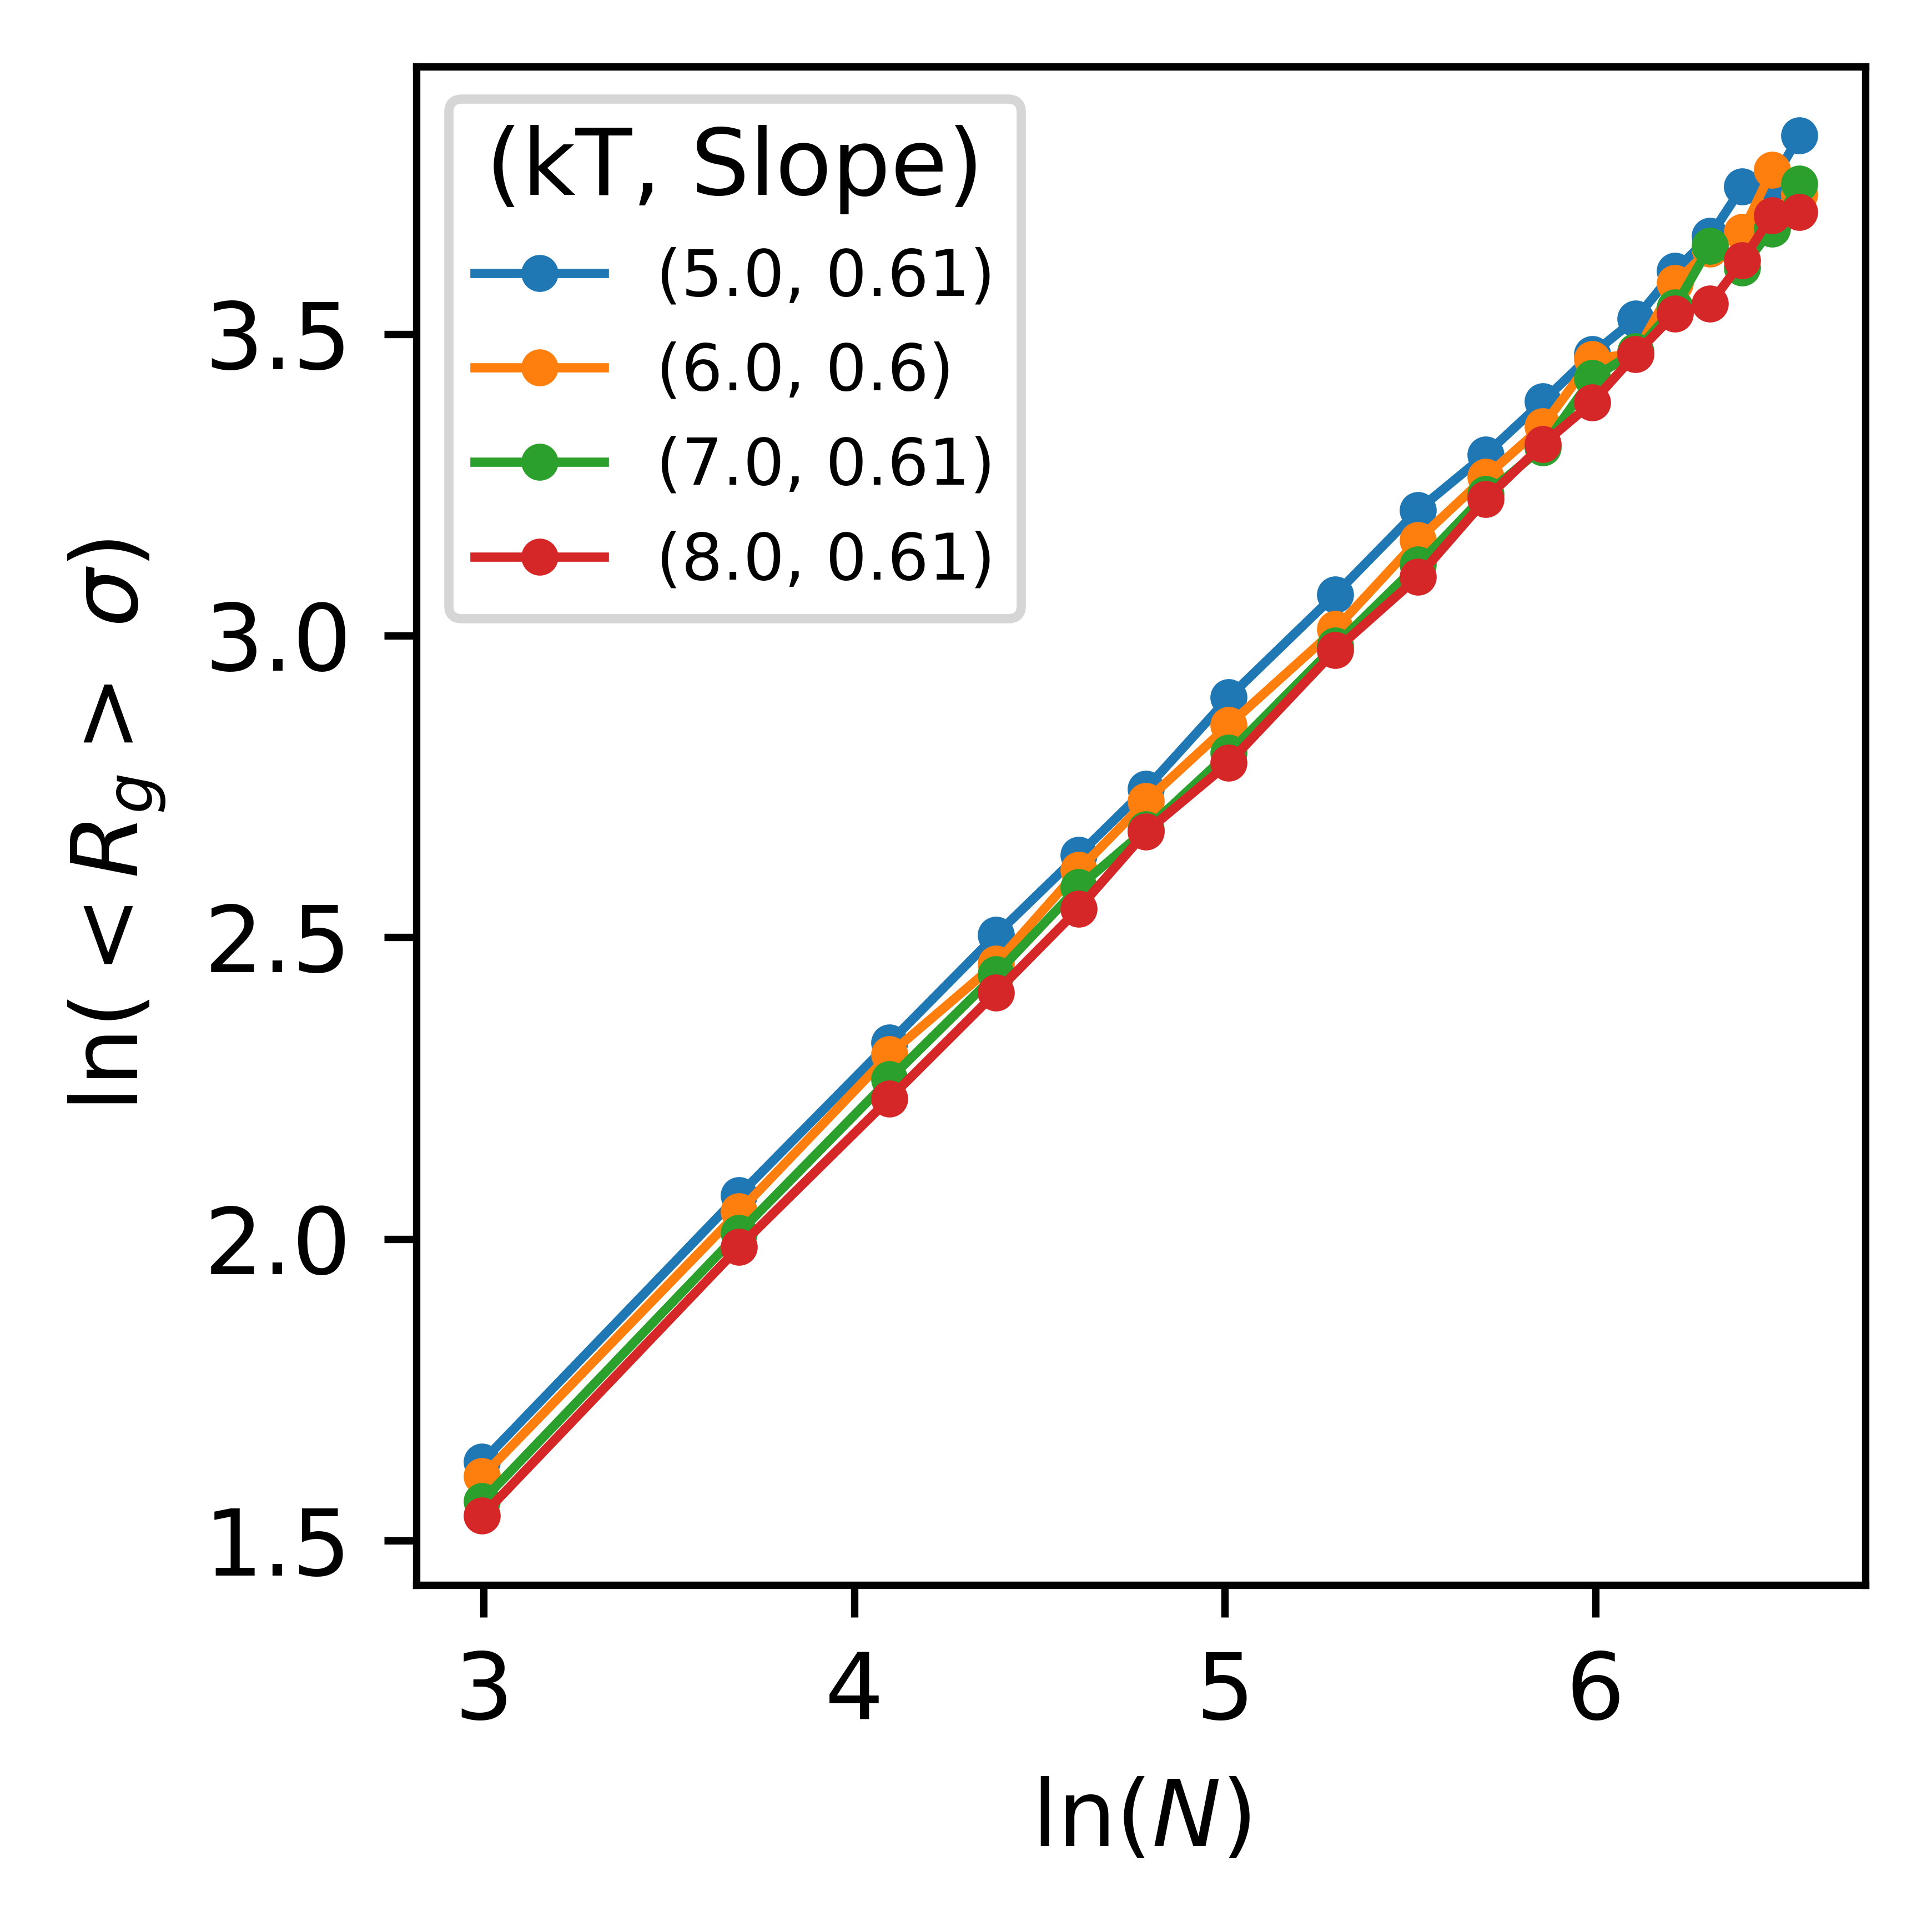

In [101]:
fig = plt.figure()

for kT in [5.0, 6.0, 7.0, 8.0]:
    x = []
    y = []
    for chain_length, jobs in cg_single_chain_proj.find_jobs(
        {"doc.sampled": True, "kT": kT}).groupby("lengths"):
        for job in jobs:
            x.append(np.log(chain_length))
            y.append(np.log(job.doc.rg_avg))
    slope, intercept, r, p, se = linregress(x=x, y=y)
    plt.plot(x, y, label=(kT, np.round(slope, 2)), marker="o")

plt.legend(title="(kT, Slope)")
plt.xlabel("$\ln(N)$")
#plt.ylabel("$\ln(<Rg>$)")
plt.ylabel(f"$\ln(<R_g>$ {length_unit})")
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig("../FIGS/log-rg-scaling-cg-model.png")
plt.show()

### End-to-End Distance:

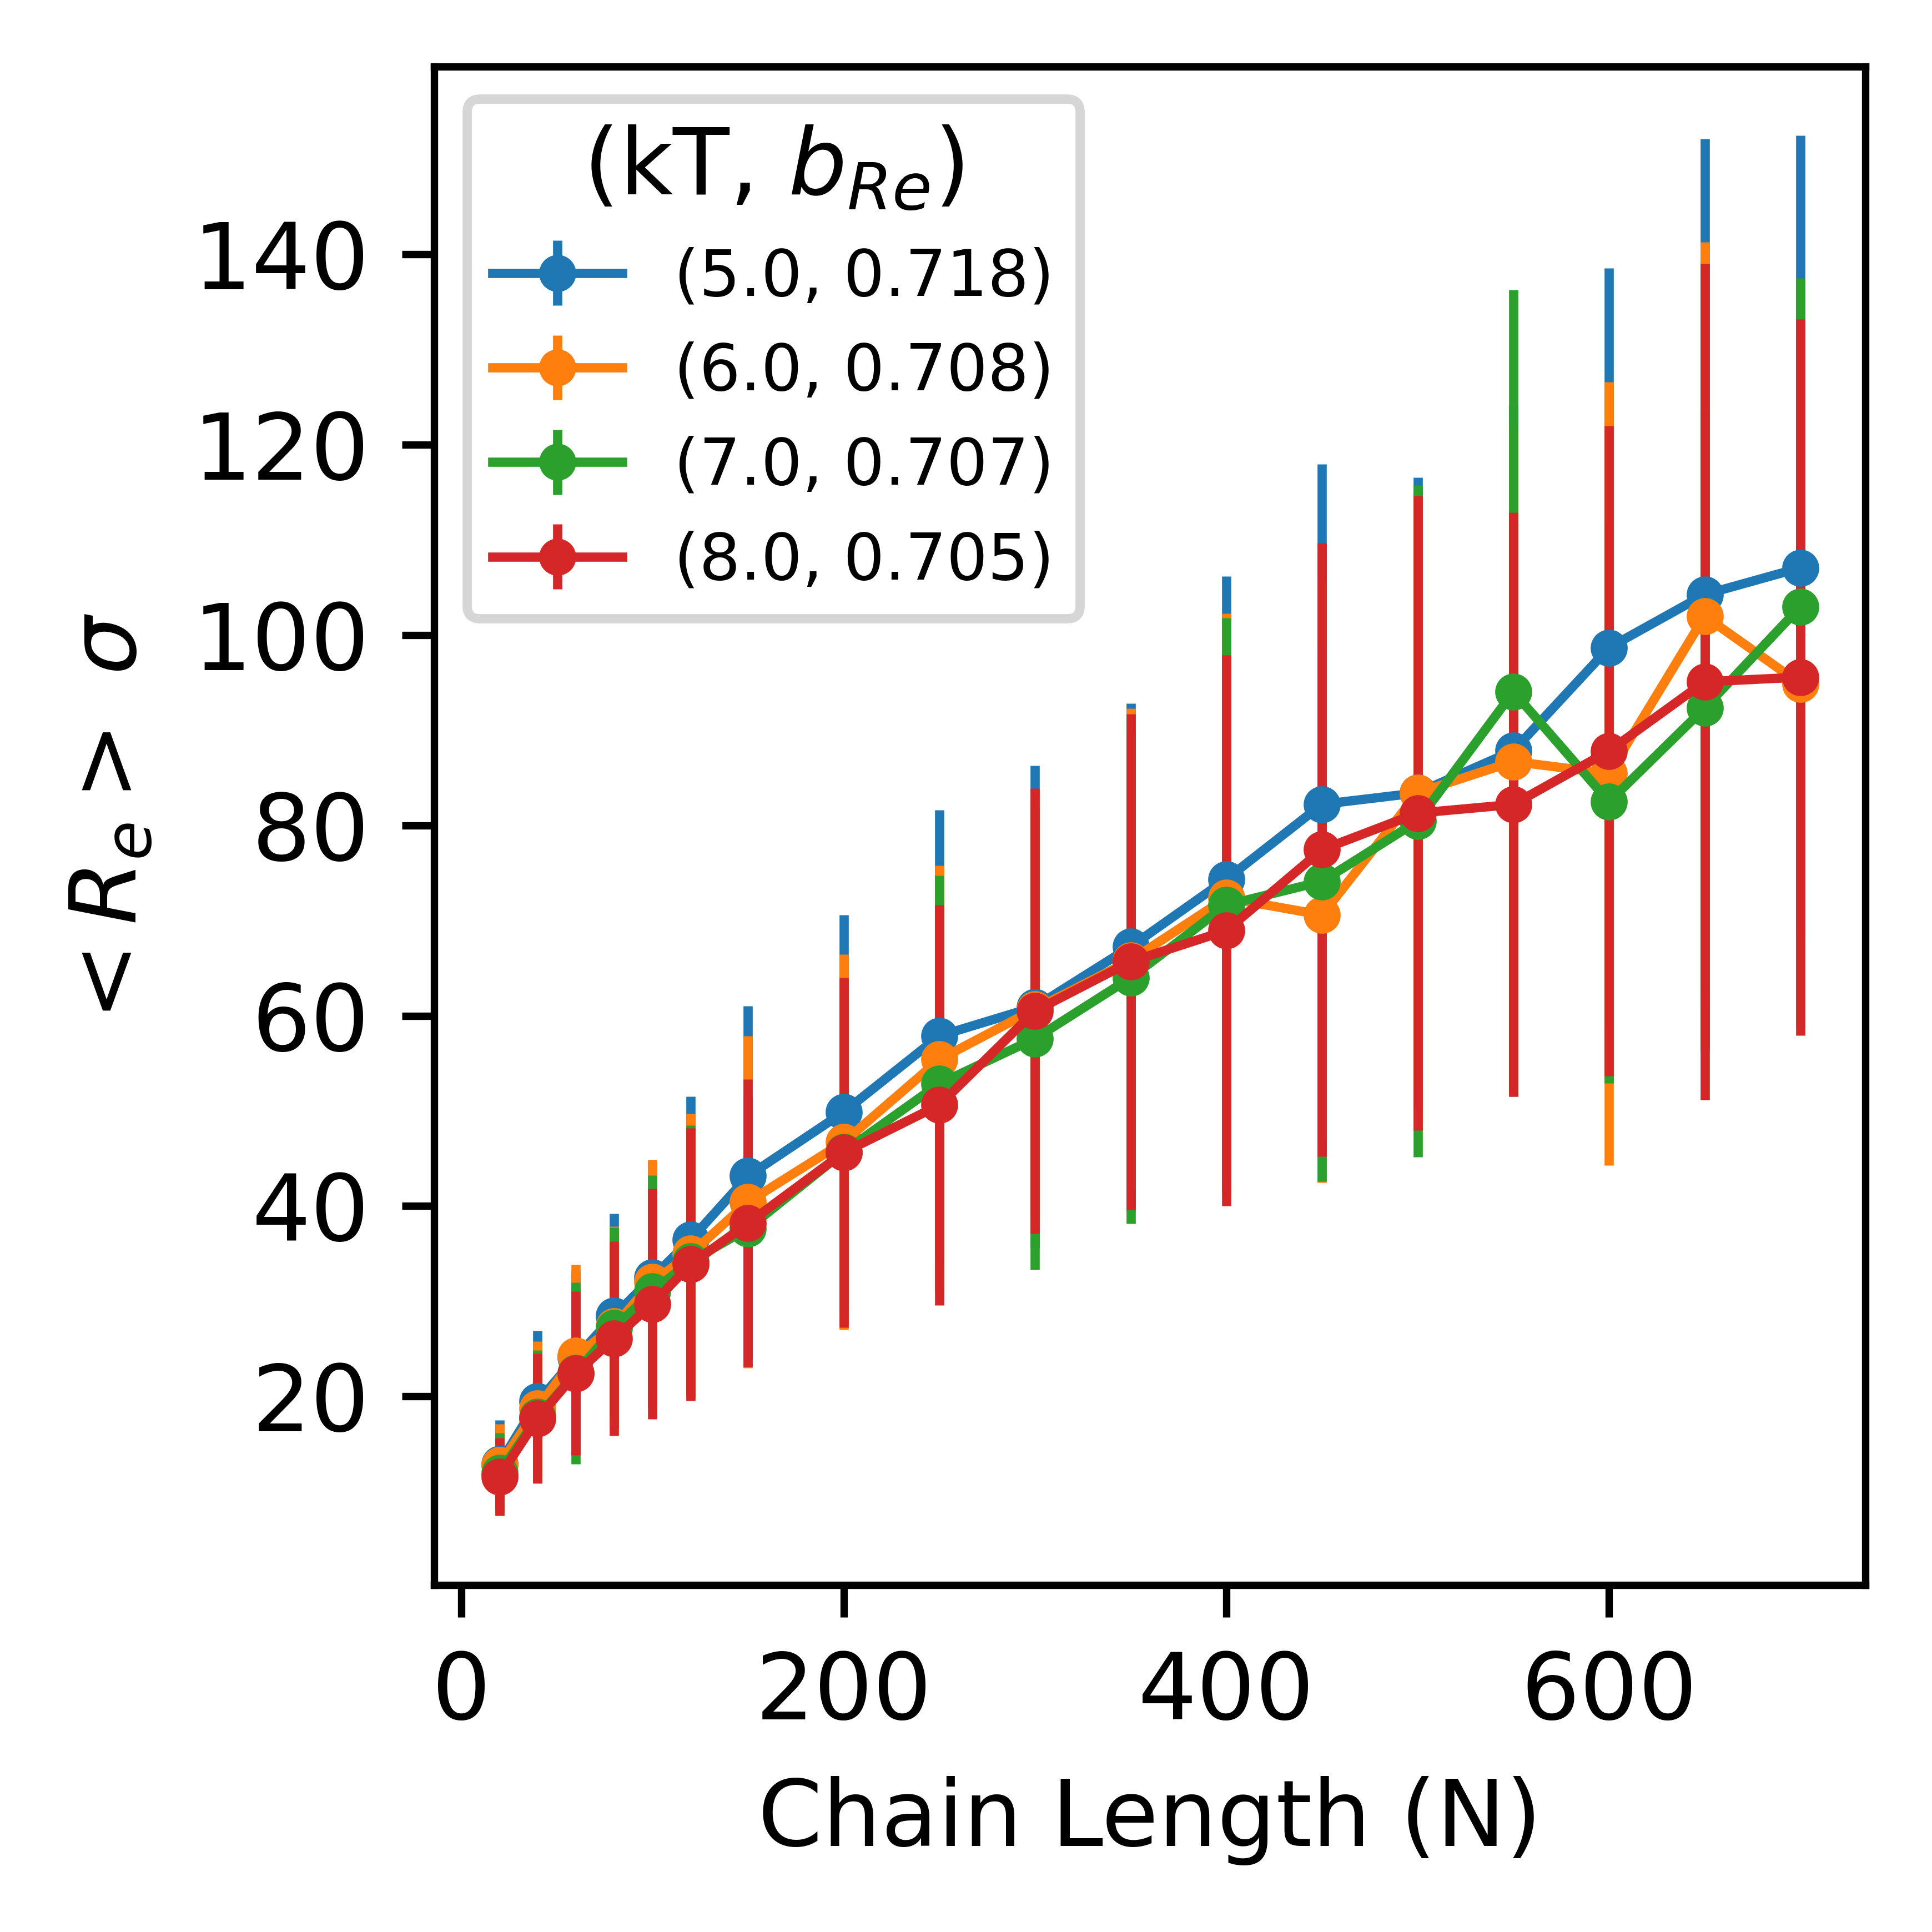

In [102]:
fig = plt.figure()

for kT in [5.0, 6.0, 7.0, 8.0]:
    x = []
    y = []
    y_err = []
    for chain_length, jobs in cg_single_chain_proj.find_jobs(
        {"doc.sampled": True, "kT": kT}).groupby("lengths"):
        for job in jobs:
            x.append(chain_length)
            y.append(job.doc.re_avg)
            y_err.append(job.doc.re_std)
    popt, pcov = curve_fit(power_scale, x, y, p0=0.5)
    plt.errorbar(
        x=x,
        y=y,
        yerr=y_err,
        marker="o",
        label=(kT, np.round(popt[0], 3))
    )

plt.legend(title="(kT, $b_{Re})$", loc="upper left")
plt.xlabel("Chain Length (N)")
plt.ylabel(f"$<R_e>$ {length_unit}")
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig("../FIGS/re-scaling-cg-model.png")
plt.show()

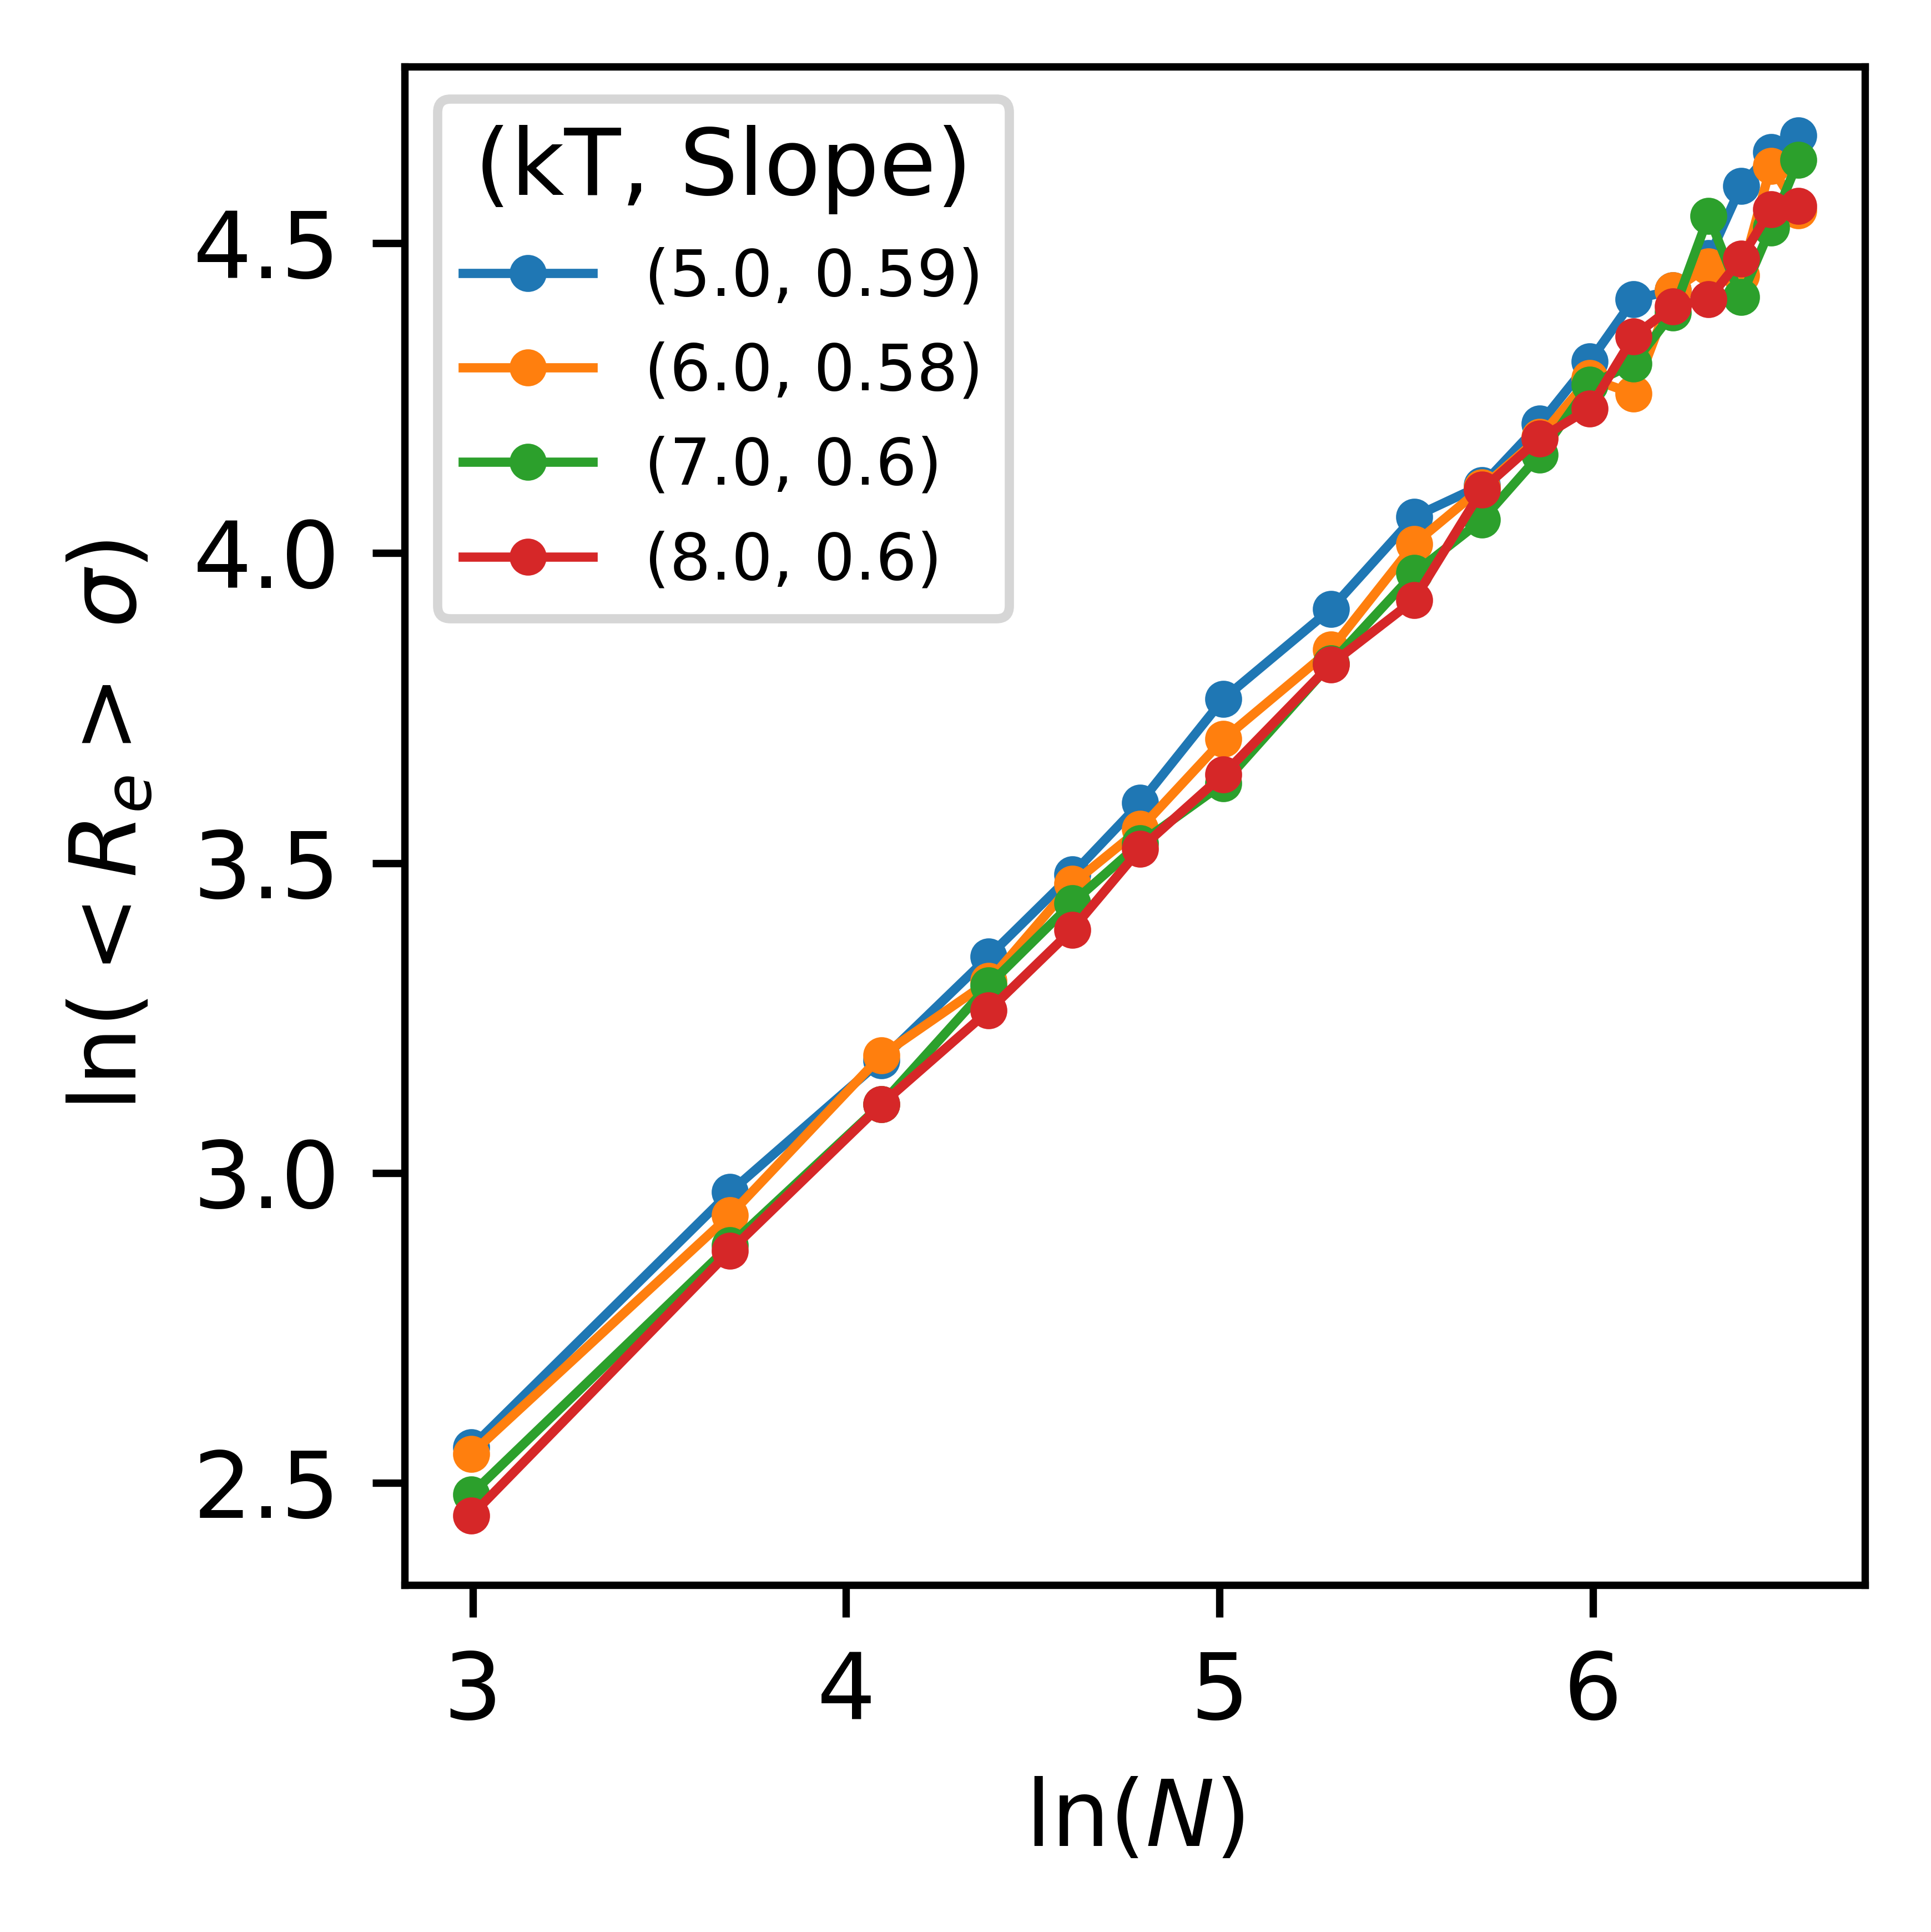

In [103]:
fig = plt.figure()

for kT in [5.0, 6.0, 7.0, 8.0]:
    x = []
    y = []
    for chain_length, jobs in cg_single_chain_proj.find_jobs(
        {"doc.sampled": True, "kT": kT}).groupby("lengths"):
        for job in jobs:
            x.append(np.log(chain_length))
            y.append(np.log(job.doc.re_avg))
            
    slope, intercept, r, p, se = linregress(x=x, y=y)
    plt.plot(x, y, label=(kT, np.round(slope, 2)), marker="o")

plt.legend(title="(kT, Slope)")
plt.xlabel("$\ln(N)$")
plt.ylabel(f"$\ln(<R_e>$ {length_unit})")
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig("../FIGS/log-re-scaling-cg-model.png")
plt.show()

# Chain Statistics: Compare Target to C.G.

In [93]:
chain_lengths = [20, 40, 60, 80]
kT = 7.0

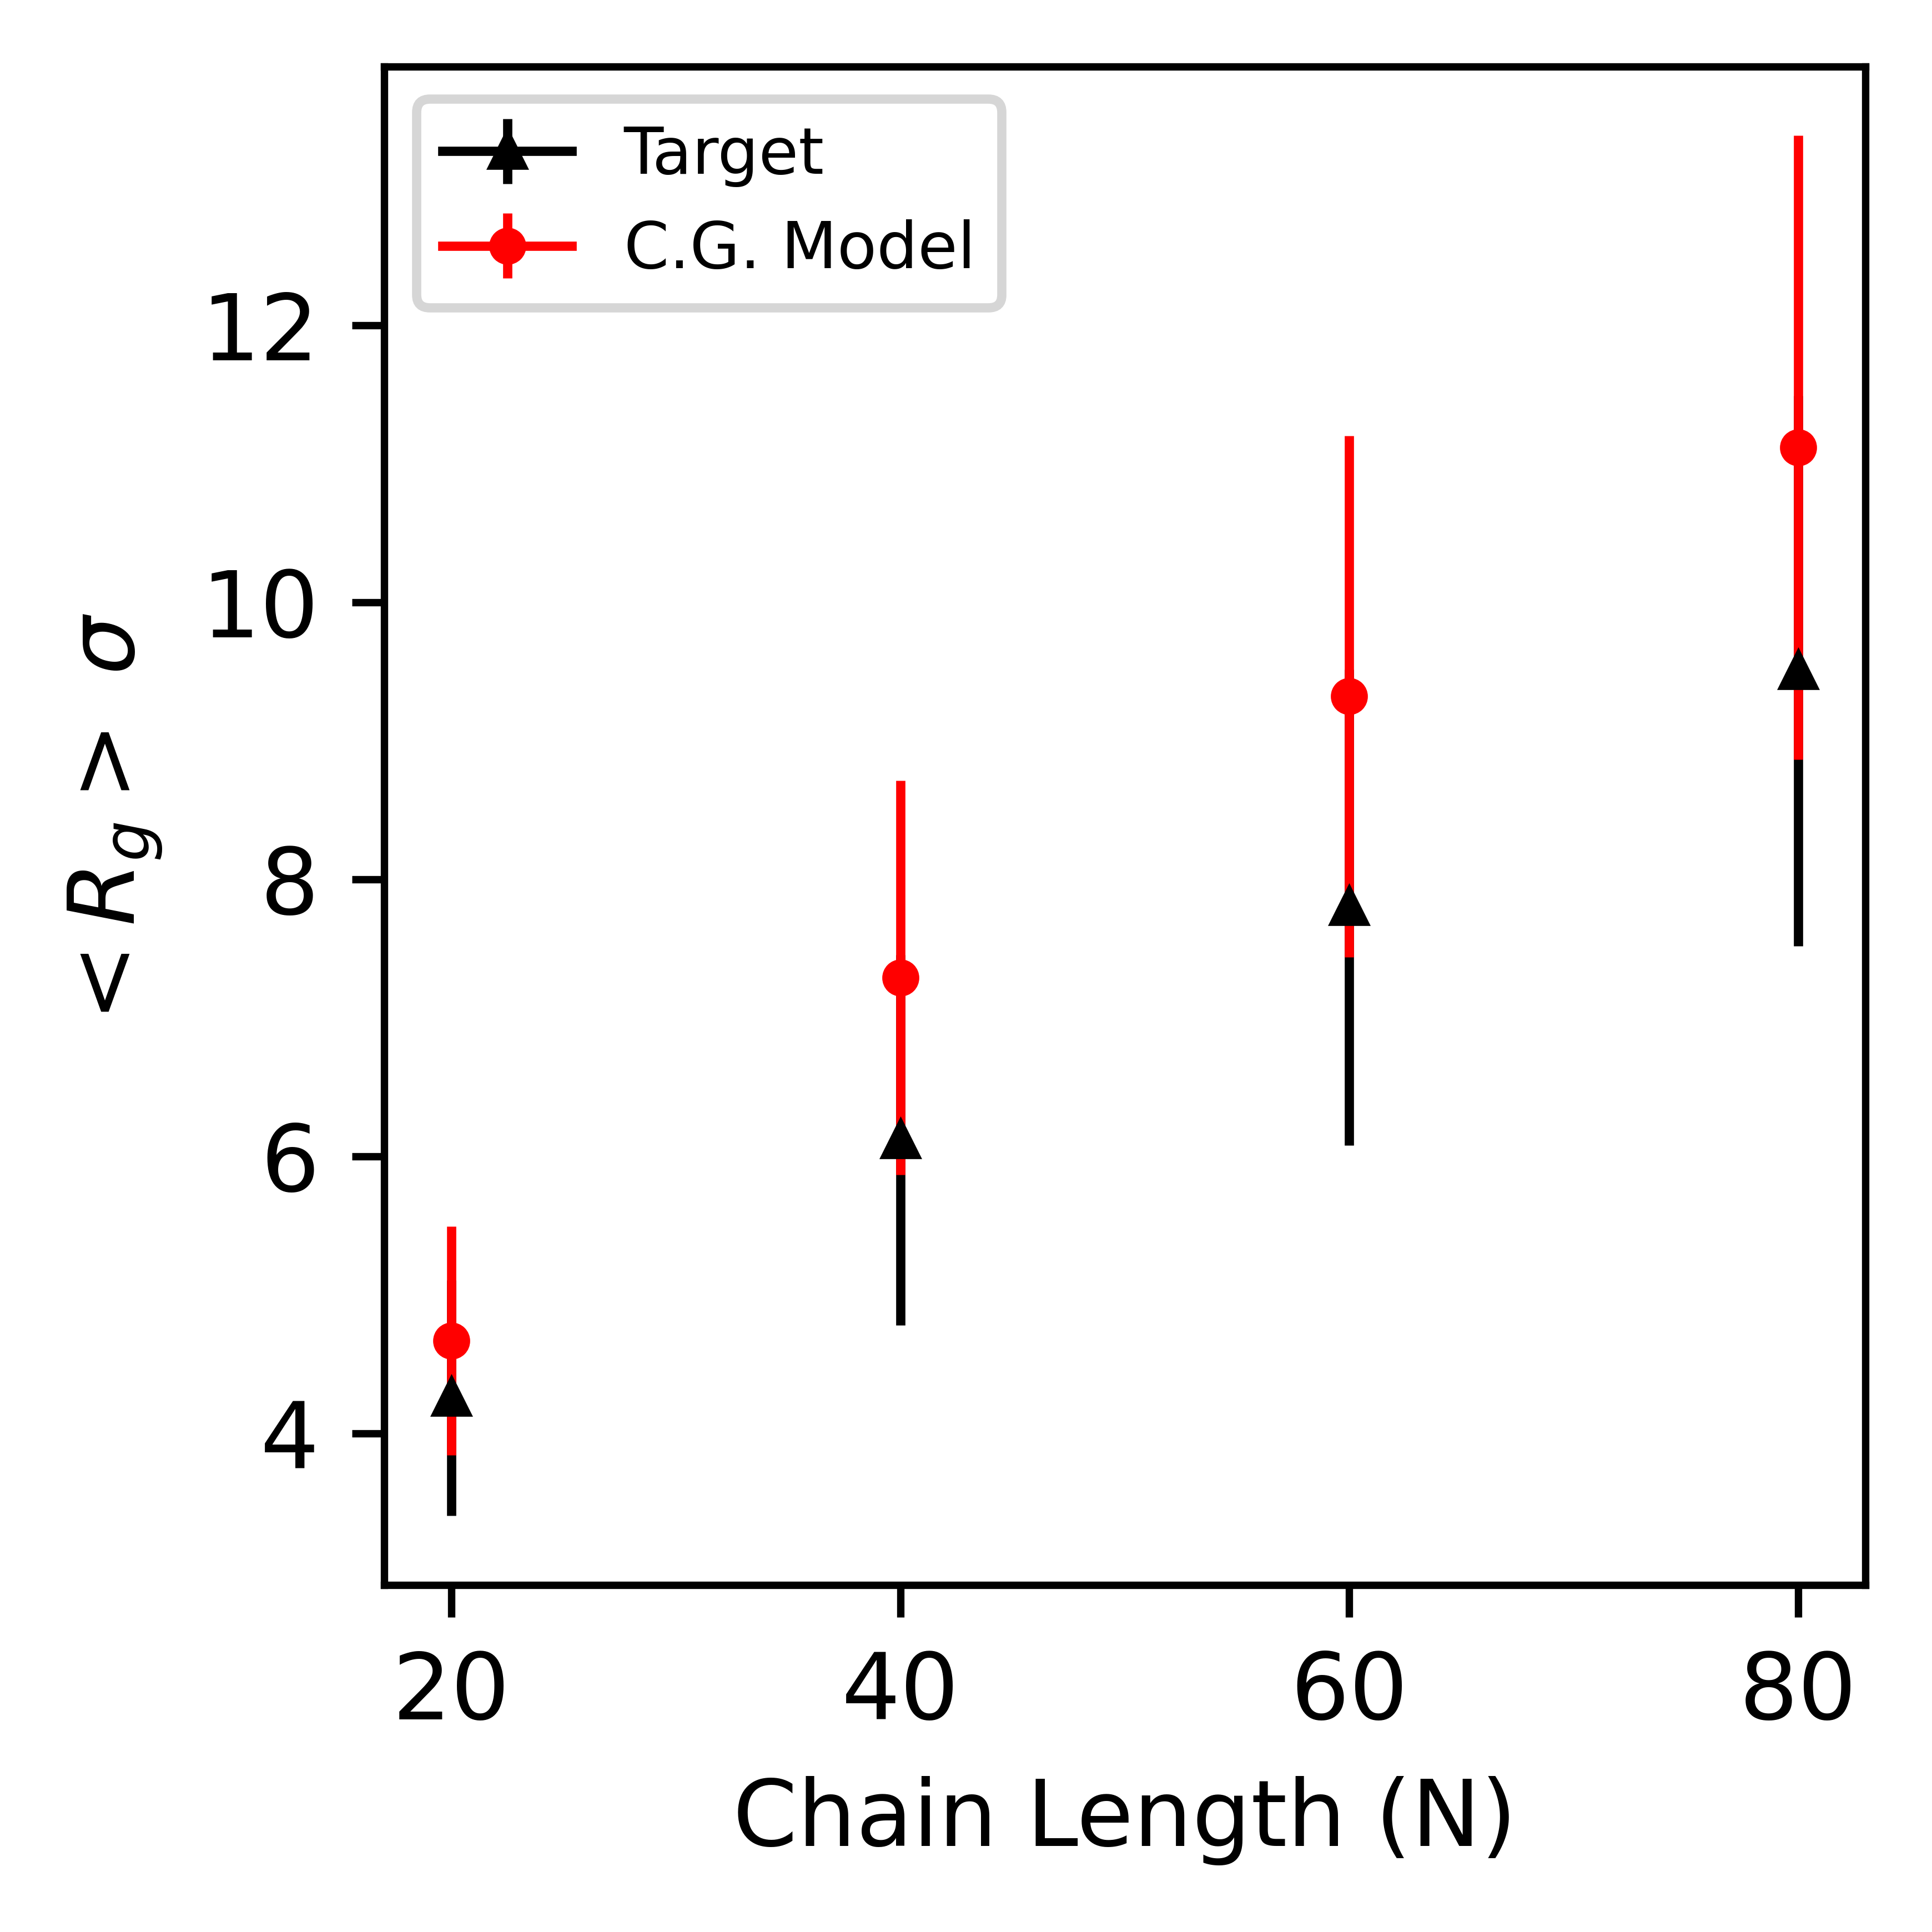

In [105]:
fig = plt.figure()
target_proj_fiter = {"kT": kT, "remove_hydrogens": True}

count = 0
for length, jobs in target_single_chain_proj.find_jobs(target_proj_fiter).groupby("lengths"):
    if length == 2:
        continue
    if count == 0:
        label = "Target"
    else:
        label = None
    for job in jobs:
        plt.errorbar(x=length, y=job.doc.rg_avg, yerr=job.doc.rg_std, marker="^", c="k", label=label)
    count += 1

count = 0
for length, jobs in cg_single_chain_proj.find_jobs({"kT": kT}).groupby("lengths"):
    if length not in chain_lengths:
        continue
    if count == 0:
        label = "C.G. Model"
    else:
        label = None
    for job in jobs:
        plt.errorbar(x=length, y=job.doc.rg_avg, yerr=job.doc.rg_std, marker="o", c="r", label=label)
        count += 1
        
plt.legend(loc="upper left")
plt.xlabel("Chain Length (N)")
plt.ylabel(f"$<R_g>$ {length_unit}")
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig("../FIGS/rg-compare-models.png")
plt.show()

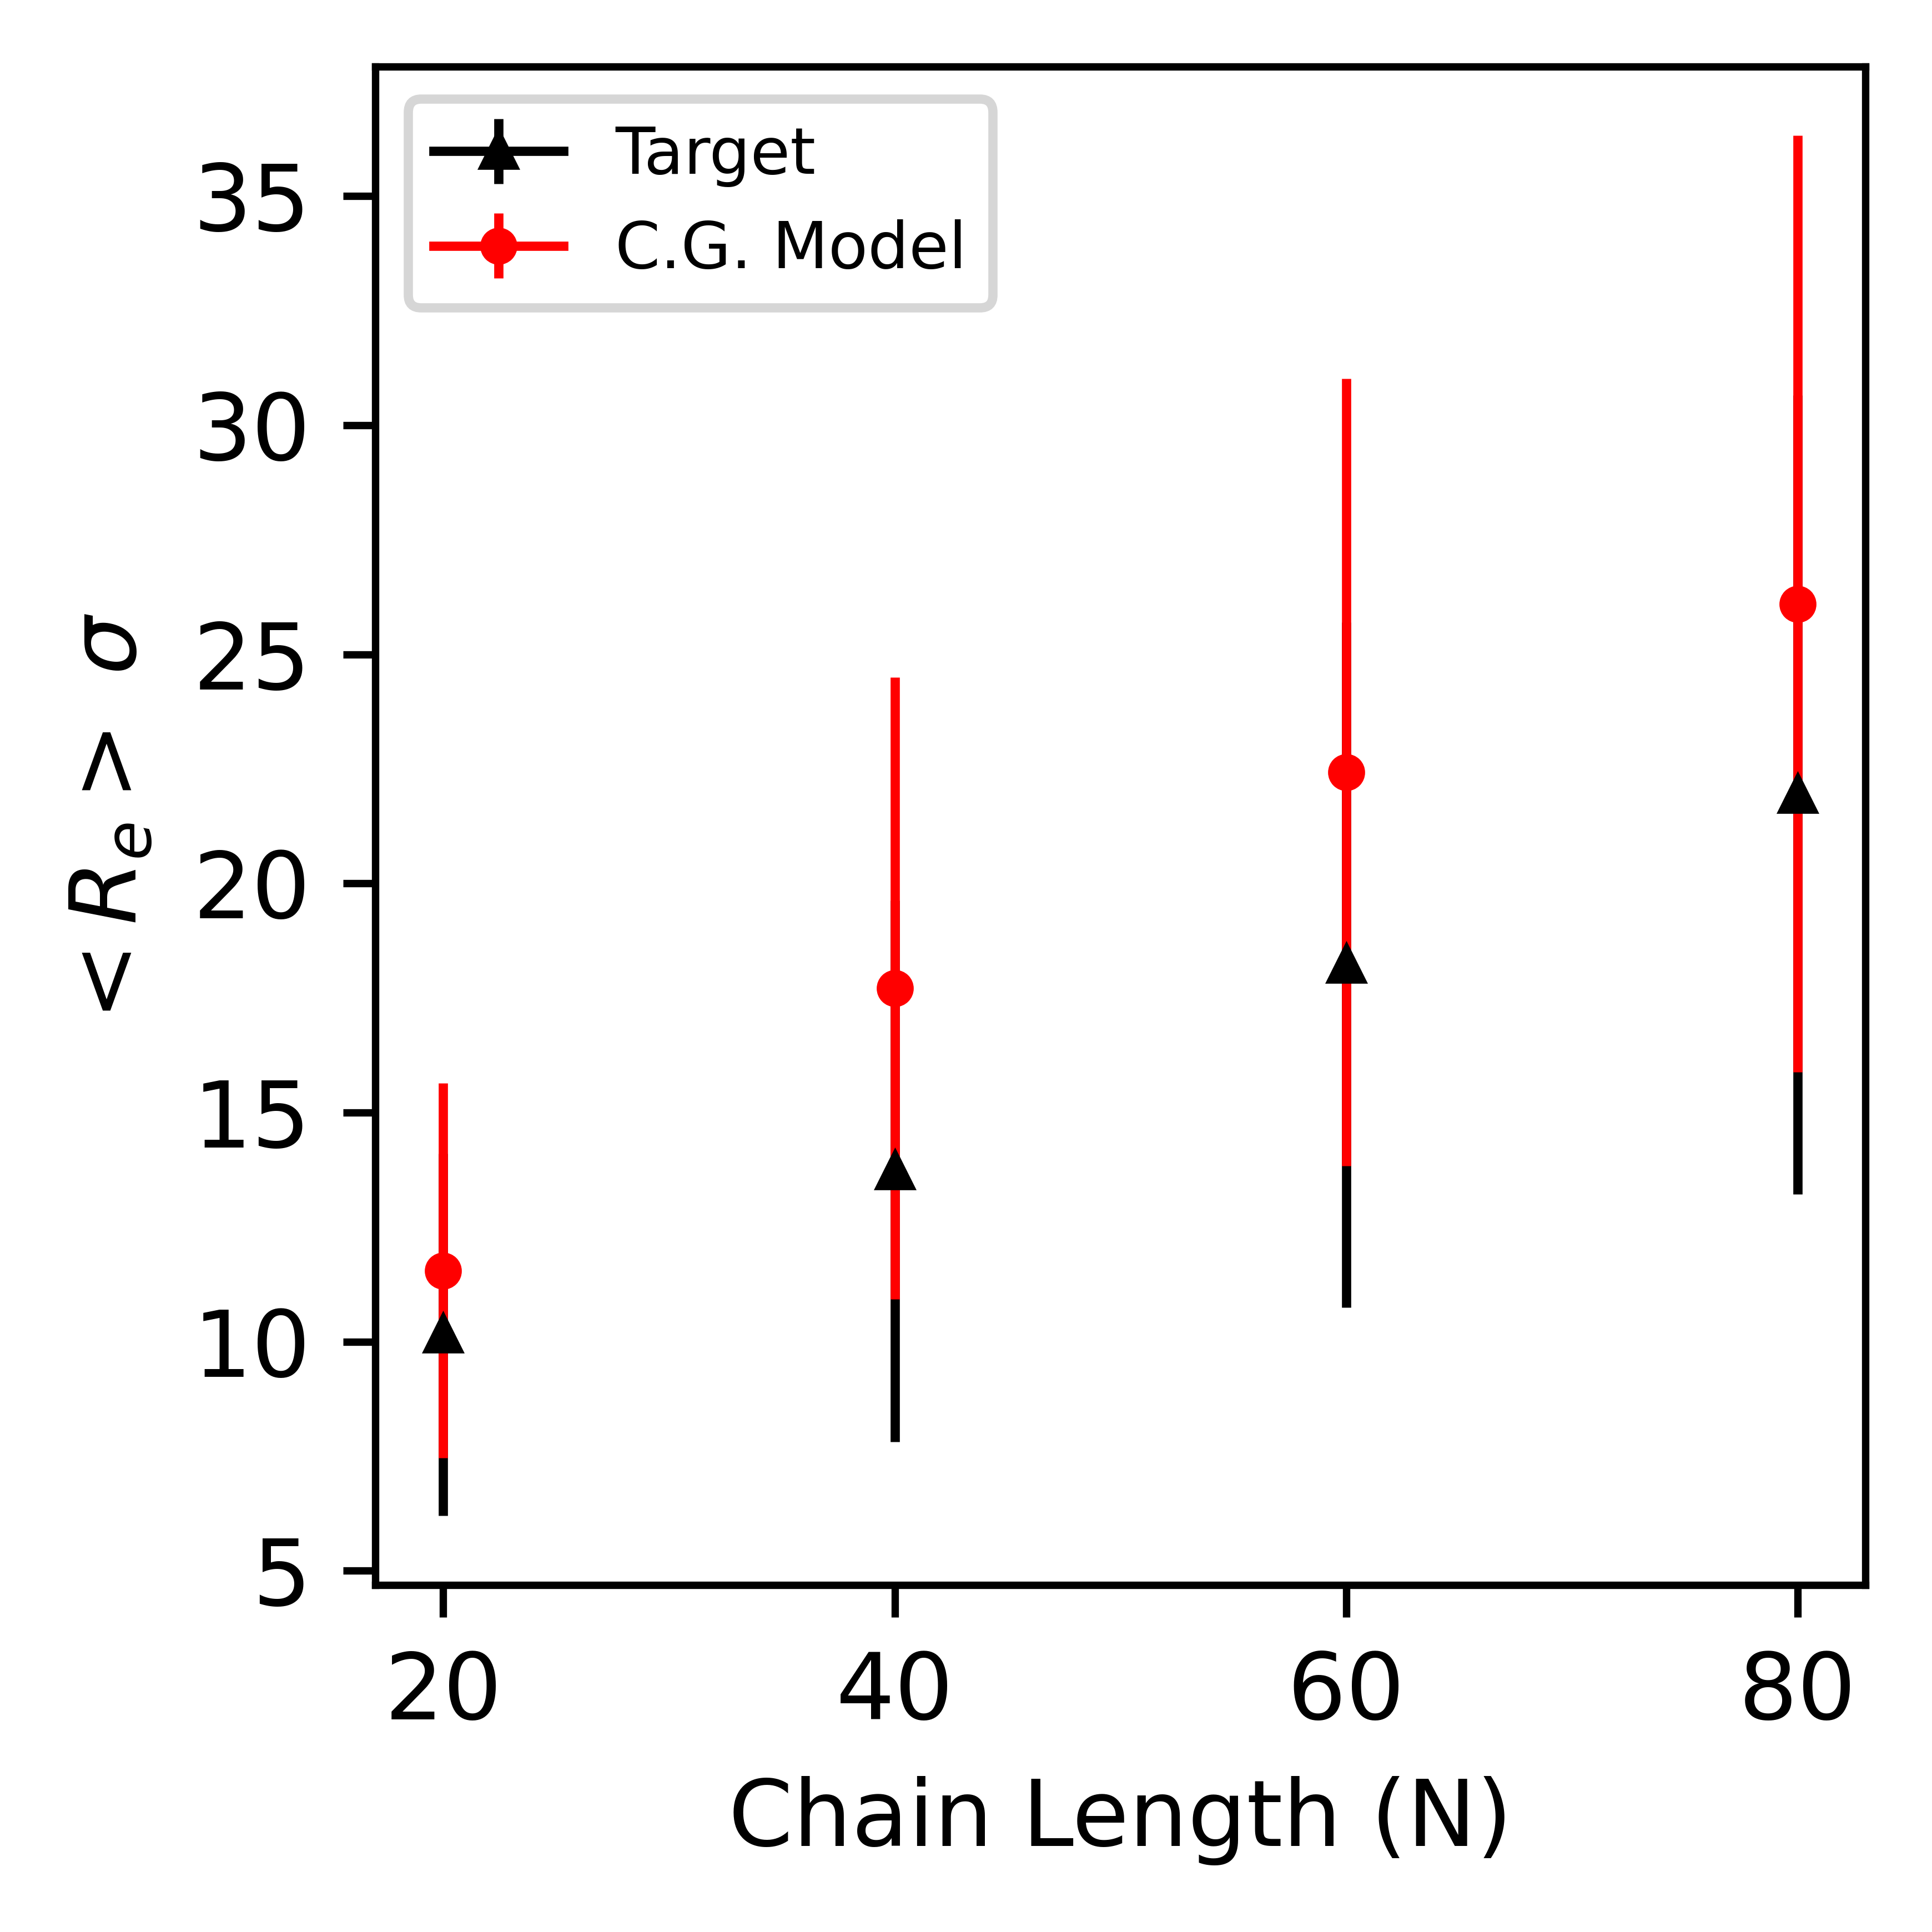

In [107]:
fig = plt.figure()
target_proj_fiter = {"kT": kT, "remove_hydrogens": True}

count = 0
for length, jobs in target_single_chain_proj.find_jobs(target_proj_fiter).groupby("lengths"):
    if length == 2:
        continue
    if count == 0:
        label = "Target"
    else:
        label = None
    for job in jobs:
        plt.errorbar(x=length, y=job.doc.re_avg, yerr=job.doc.re_std, marker="^", c="k", label=label)
    count += 1

count = 0
for length, jobs in cg_single_chain_proj.find_jobs({"kT": kT}).groupby("lengths"):
    if length not in chain_lengths:
        continue
    if count == 0:
        label = "C.G. Model"
    else:
        label = None
    for job in jobs:
        plt.errorbar(x=length, y=job.doc.re_avg, yerr=job.doc.re_std, marker="o", c="r", label=label)
        count += 1
        
plt.legend(loc="upper left")
plt.xlabel("Chain Length (N)")
plt.ylabel(f"$<R_e>$ {length_unit}")
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig("../FIGS/re-compare-models.png")
plt.show()